In [28]:
import io
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyclustering
import requests
import scipy.sparse as sparse
import seaborn as sns

from graph_tool.all import *
from math import comb
from pyclustering.cluster.kmedians import kmedians
from scipy.sparse import coo_matrix
from scipy import stats
from sklearn import cluster, metrics

# SBM Noise Matrices

In [2]:
def get_coo_matrix(G, symmetric=False):
    nnodes = G.num_vertices()

    rows = []
    cols = []
    data = []

    for e in G.edges():
        src = e.source()
        tgt = e.target()
        rows.append(src)
        cols.append(tgt)
        data.append(1)  # unweighted graph

        if symmetric:
        # For undirected graphs
            rows.append(tgt)
            cols.append(src)
            data.append(1)

    # Create the adjacency matrix in COO format
    adj_matrix_coo = coo_matrix((data, (rows, cols)), shape=(nnodes, nnodes))
    return adj_matrix_coo

def calc_all_densities(adj_matrix, block_list):

    block_labels, block_sizes = np.unique(block_list, return_counts=True)
    nblocks = len(block_labels)
    density_matrix = np.zeros((nblocks, nblocks))

    for i, j, v in zip(adj_matrix.row, adj_matrix.col, adj_matrix.data):
        density_matrix[block_list[i], block_list[j]] += 1

    for i in range(len(block_labels)):
        for j in range(len(block_labels)):
            density_matrix[block_labels[i],
                           block_labels[j]] = np.max([density_matrix[block_labels[i],
                                                                     block_labels[j]], 1])/(block_sizes[i]*block_sizes[j])

    return(density_matrix)

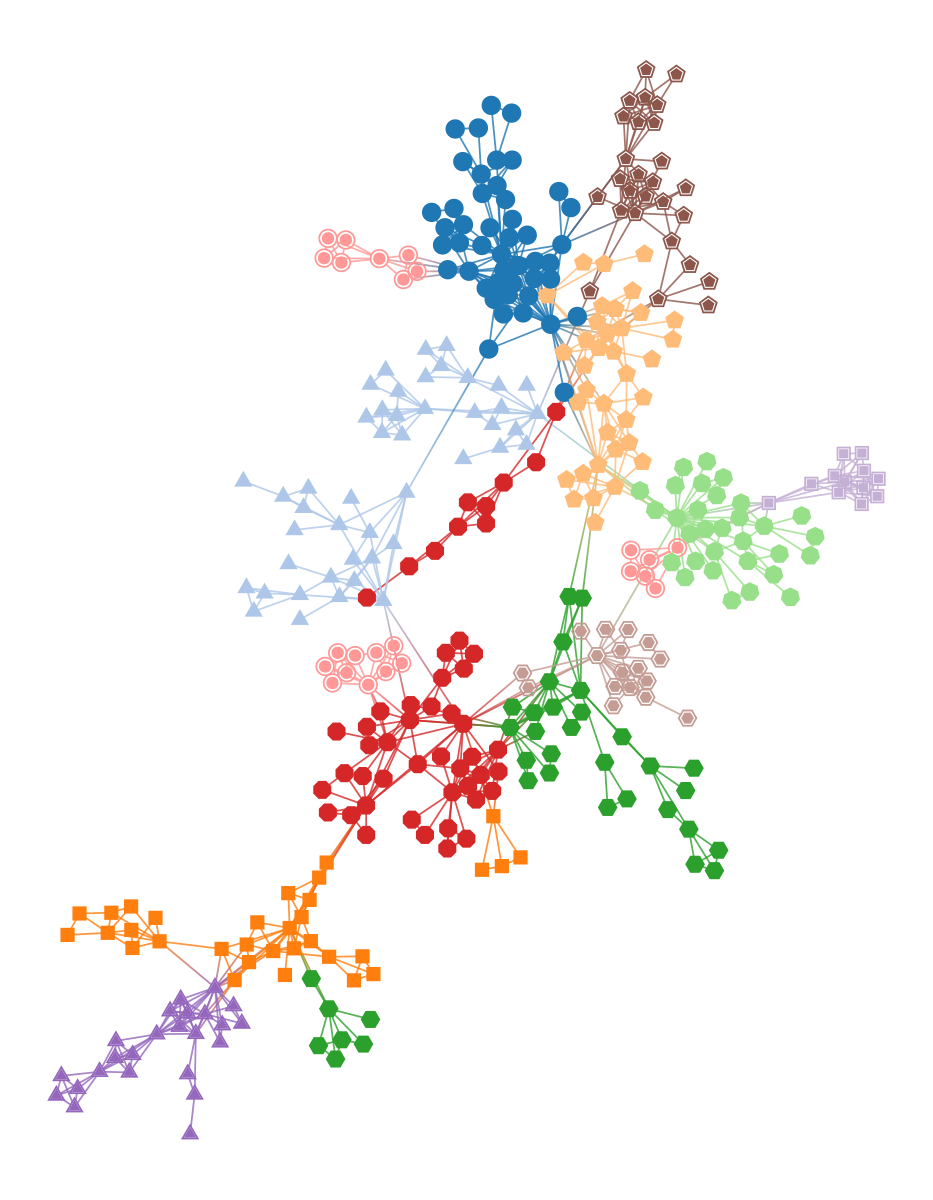

<GraphView object, undirected, with 379 vertices and 914 edges, 2 internal vertex properties, 1 internal edge property, 2 internal graph properties, at 0x1670b9590>


In [3]:
# Load graph
# G = collection.ns['power'] #['football'] #["uni_email"]     #['cond-mat'] #   #

G = collection.data['netscience']  # ['polblogs']
G = extract_largest_component(G, prune=True)

remove_parallel_edges(G)
remove_self_loops(G)
G= GraphView(G, directed=False)


# Inference of blockstate
state = minimize_blockmodel_dl(G,  multilevel_mcmc_args={'niter':2})
b = contiguous_map(state.get_blocks())
state = state.copy(b=b)
block_list = state.get_blocks().a
adj_matrix = get_coo_matrix(G)
density_matrix = calc_all_densities(adj_matrix, block_list)


# draw
pos = sfdp_layout(G, groups=state.get_blocks(), gamma=0.0000001)
state.draw(pos=pos, vertex_shape=state.get_blocks())

print(G)

In [4]:
def add_SBM(adj_matrix, block_list, density_matrix, epsilon):

    W_01 = np.zeros_like(density_matrix)
    W_11 = np.zeros_like(density_matrix)
    N_C = np.zeros_like(density_matrix)

    block_labels, block_sizes = np.unique(block_list, return_counts=True)
    for i in range(len(block_labels)):
        for j in range(len(block_labels)):
            p_00, p_11 = prob_from_eps_density(epsilon, density_matrix[i,j])
            N_C[i,j] = block_sizes[block_labels[i]]*block_sizes[block_labels[j]]
            W_01[i,j] = int((1-p_00)*N_C[i,j])
            W_11[i,j] = int(p_11*N_C[i,j])

    np.fill_diagonal(W_11, W_11.diagonal()*2)    # diagonal should have twice the avg num of edges

    g_keep = generate_sbm(block_list, W_11, micro_ers=True)
    m_keep = get_coo_matrix(g_keep, symmetric=True)

    M_keep = adj_matrix.multiply(m_keep)
    M_keep.tocoo().data = np.ones_like(M_keep.tocoo().data)
    print(m_keep.sum(), M_keep.sum(), adj_matrix.sum())


    g_add = generate_sbm(block_list, W_01)
    m_add = get_coo_matrix(g_add, symmetric=True)


    # prompt: generate a sparse coo matrix with the pairs in m_add but not in M

    # Find pairs present in m_add but not in M
    m_add_pairs = set(zip(m_add.row, m_add.col))
    M_pairs = set(zip(adj_matrix.row, adj_matrix.col))

    pairs_in_m_add_not_in_M = list(m_add_pairs - M_pairs)

    # Create a sparse COO matrix from the identified pairs
    rows = [pair[0] for pair in pairs_in_m_add_not_in_M]
    cols = [pair[1] for pair in pairs_in_m_add_not_in_M]
    data = [1] * len(rows)  # Assuming a value of 1 for the new matrix

    M_add = sparse.coo_matrix((data, (rows, cols)), shape=adj_matrix.shape)

    Noisy_M = M_add + M_keep
    Noisy_M = Noisy_M.tocoo()
    # NoisyG = coo_matrix_to_graphtool(Noisy_M)
    # NoisyG
    return(Noisy_M)

def prob_from_eps_density(epsilon, density):
    density = max(density, 1e-10)  # or any small positive value
    denom = (np.exp(epsilon)- 1 + (1/density))
    z = 1/denom
    v = (1 - z, np.exp(epsilon) * z)  # vector v=(p_00, p_11) that preserves Sparseness and Epsilon-LDP
    # print(v)
    return v

def coo_matrix_to_graphtool(coo_matrix):
    g = Graph(directed=False)  # Create an undirected graph
    g.add_vertex(coo_matrix.shape[0])

    for i, j, v in zip(coo_matrix.row, coo_matrix.col, coo_matrix.data):
        g.add_edge(g.vertex(i), g.vertex(j))

    remove_parallel_edges(g)
    remove_self_loops(g)
    return g

# Figure

2810 202 914
<Graph object, undirected, with 379 vertices and 536 edges, at 0x16701e690>


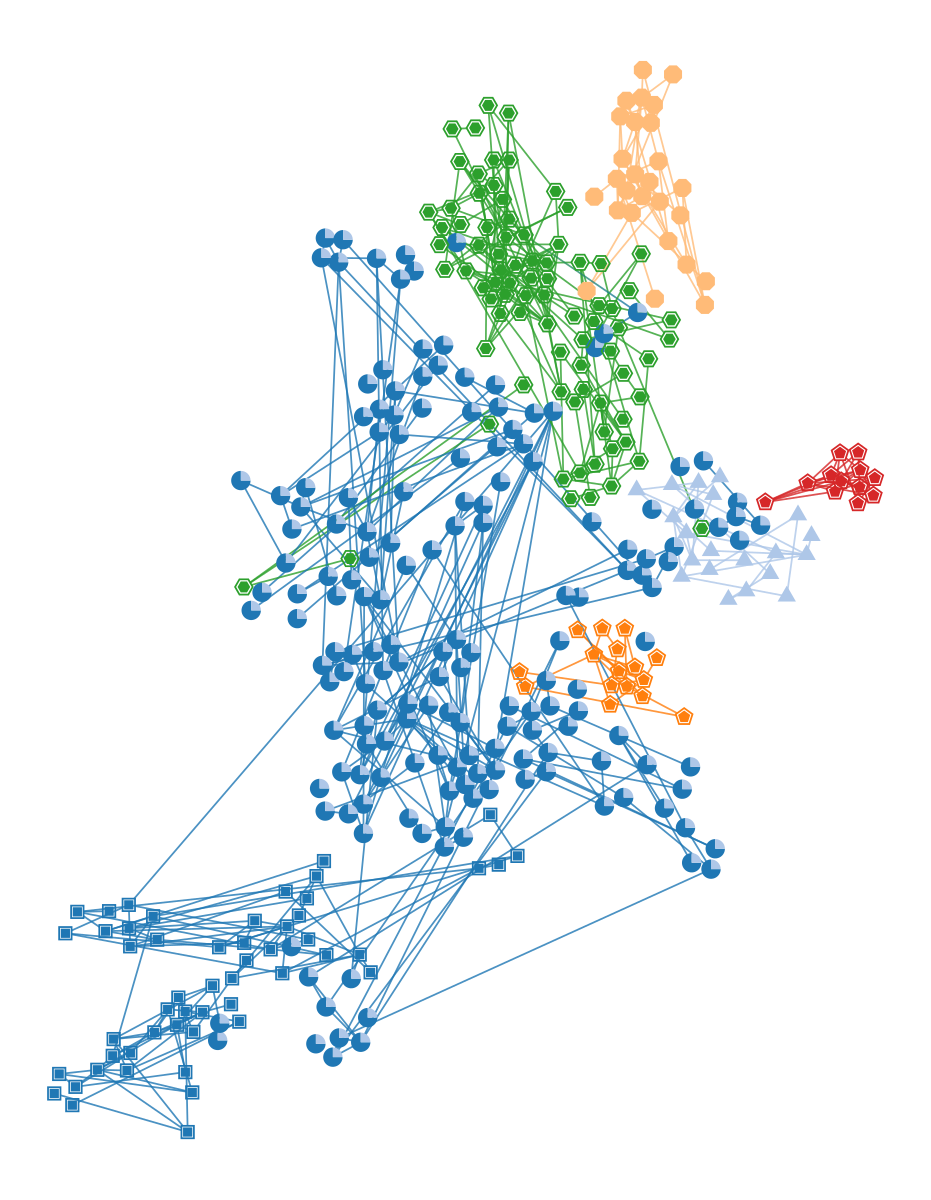

0.5
0.525065963060686
13444 853 914
<Graph object, undirected, with 379 vertices and 744 edges, at 0x1670173e0>


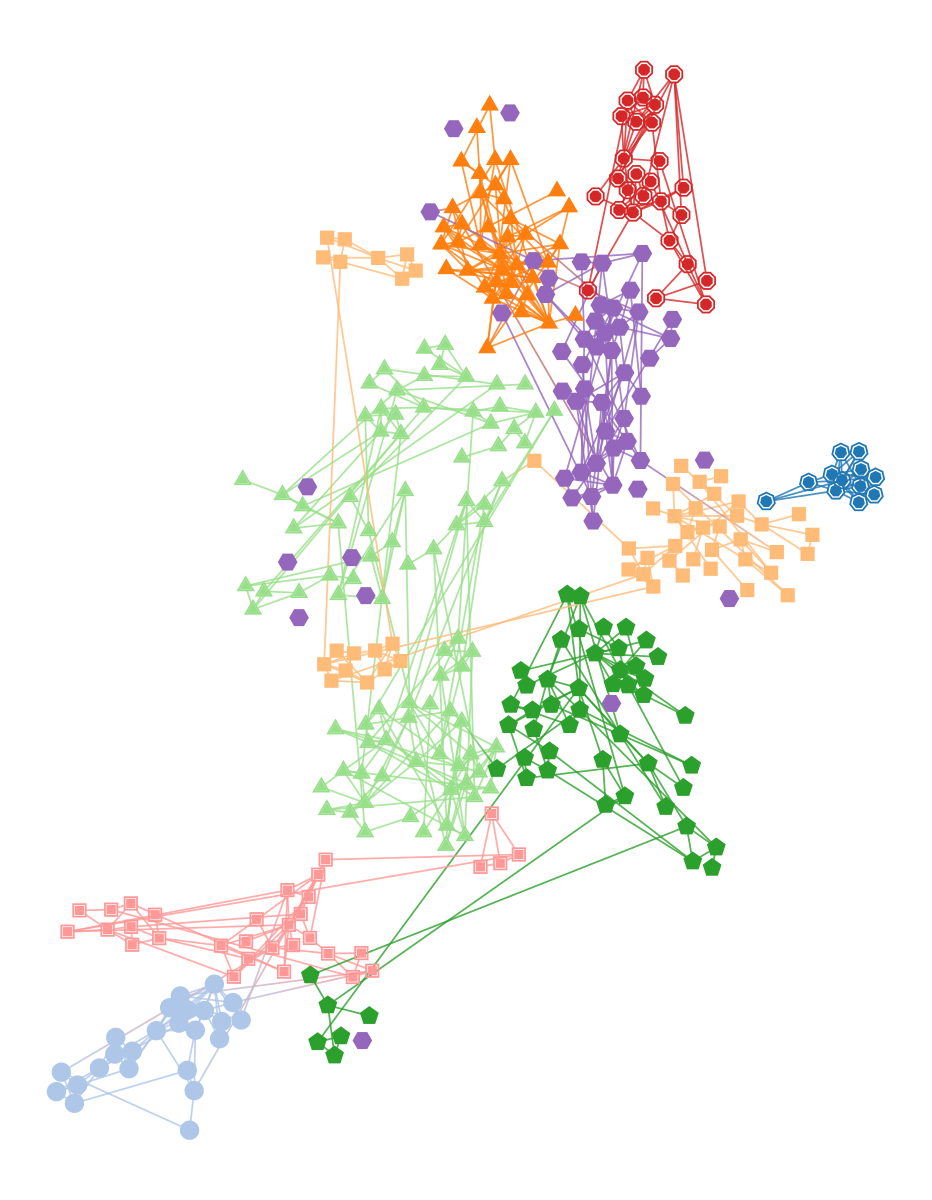

2.5
0.7335092348284961
110742 1753 914
<Graph object, undirected, with 379 vertices and 758 edges, at 0x167327110>


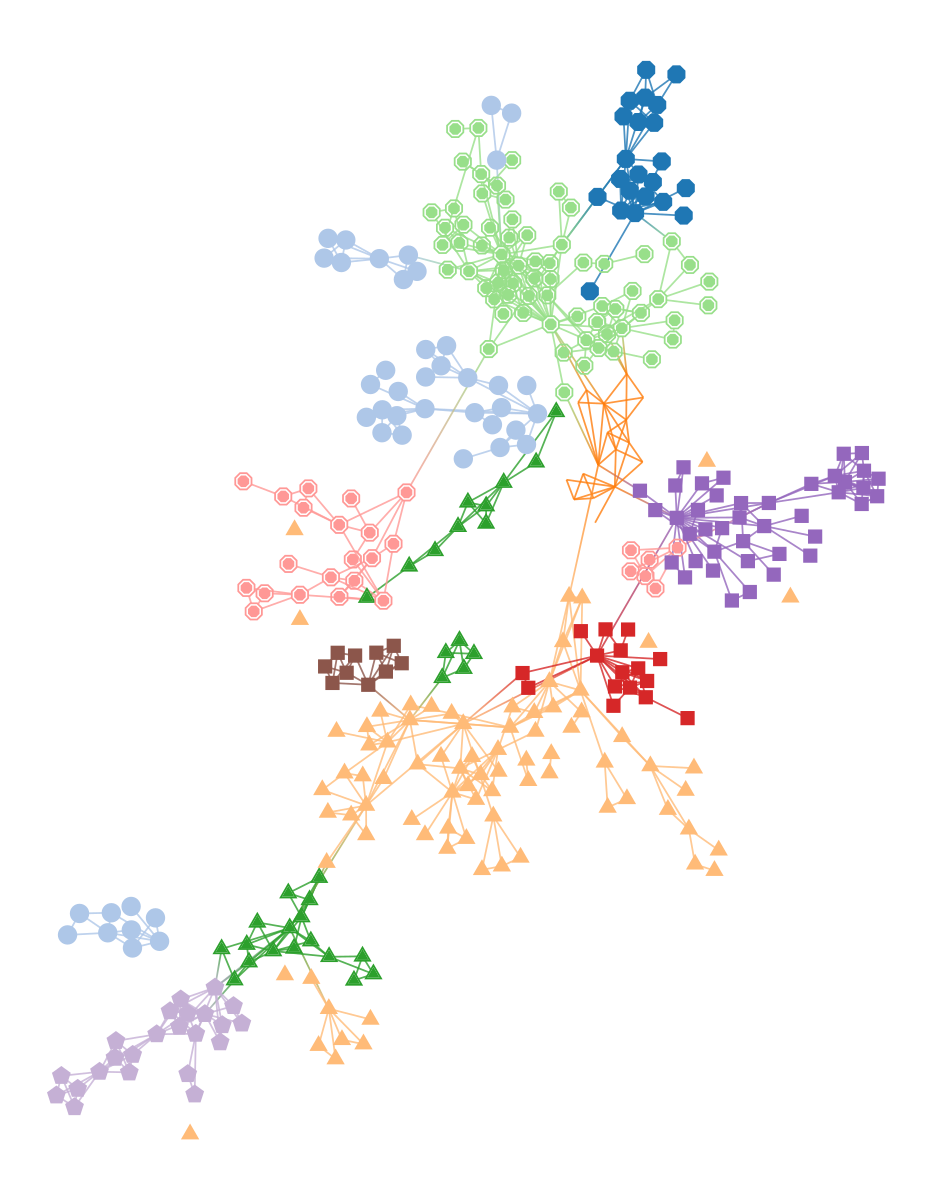

7.5
0.6306068601583114


In [5]:
# nous EXPERIMENT Sparse :))
      # https://graph-tool.skewed.de/static/doc/demos/inference/inference.html#inferring-the-best-partition

for epsilon in [0.5 ,2.5 ,7.5]:

    MG = add_SBM(adj_matrix, block_list, density_matrix, epsilon)
    NoisyG = coo_matrix_to_graphtool(MG)
    print(NoisyG)

    # # plot modified graph
    stateN = minimize_blockmodel_dl(NoisyG,  multilevel_mcmc_args={'niter':2})
    stateN.draw(pos=pos, vertex_shape=stateN.get_blocks())

    print(epsilon)
    # metrics
    print(graph_tool.inference.partition_overlap(state.get_blocks().a, stateN.get_blocks().a, norm=True))
    # print(graph_tool.inference.mutual_information(state.get_blocks().a, stateN.get_blocks().a, norm=True))


# Robustness

In [6]:
# EXPERIMENTS ROBUSTNESS

# Inference of blockstate
# names = ['polblogs', 'netscience', 'power']
names = ['power']
dict_datasets = {}

for name in names:
    G = collection.data[name]
    G = extract_largest_component(G, prune=True)

    remove_parallel_edges(G)
    remove_self_loops(G)
    G= GraphView(G, directed=False)

    dict_exp = {}
    for i in range(5):
        state = minimize_blockmodel_dl(G,  multilevel_mcmc_args={'niter':2})
        b = contiguous_map(state.get_blocks())
        state = state.copy(b=b)
        block_list = state.get_blocks().a
        adj_matrix = get_coo_matrix(G)
        density_matrix = calc_all_densities(adj_matrix, block_list)

        dict_iter = {}
        for j in range(5):
            dict_overlap = {}
            for epsilon in  np.arange(0.25, 2.1, 0.25):

                MG = add_SBM(adj_matrix, block_list, density_matrix, epsilon)
                NoisyG = coo_matrix_to_graphtool(MG)
                stateN = minimize_blockmodel_dl(NoisyG,  multilevel_mcmc_args={'niter':2})

                print(epsilon, graph_tool.inference.partition_overlap(state.get_blocks().a, stateN.get_blocks().a, norm=True))
                dict_overlap[epsilon] = graph_tool.inference.partition_overlap(state.get_blocks().a, stateN.get_blocks().a, norm=True)

            dict_iter[j] = dict_overlap
            print(j, 'iteration done')
        dict_exp[i] = dict_iter
        print(i, 'experiment done')
    dict_datasets[name] = dict_exp

16530 81 6594
0.25 0.18255413883829186
21100 112 6594
0.5 0.18255413883829186
27284 138 6594
0.75 0.18255413883829186
34748 190 6594
1.0 0.18255413883829186
44590 206 6594
1.25 0.19085205424003238
57048 261 6594
1.5 0.18255413883829186
72794 389 6594
1.75 0.18255413883829186
92940 456 6594
2.0 0.18255413883829186
0 iteration done
16530 96 6594
0.25 0.18255413883829186
21100 109 6594
0.5 0.18255413883829186
27284 134 6594
0.75 0.18255413883829186
34748 155 6594
1.0 0.18255413883829186
44590 244 6594
1.25 0.18255413883829186
57048 290 6594
1.5 0.20036429872495445
72794 351 6594
1.75 0.19935235782230318
92940 468 6594
2.0 0.2001619105444242
1 iteration done
16530 70 6594
0.25 0.2005666869054847
21100 101 6594
0.5 0.18255413883829186
27284 128 6594
0.75 0.18255413883829186
34748 168 6594
1.0 0.18255413883829186
44590 211 6594
1.25 0.18255413883829186
57048 278 6594
1.5 0.18255413883829186
72794 349 6594
1.75 0.18255413883829186
92940 445 6594
2.0 0.18255413883829186
2 iteration done
16530 

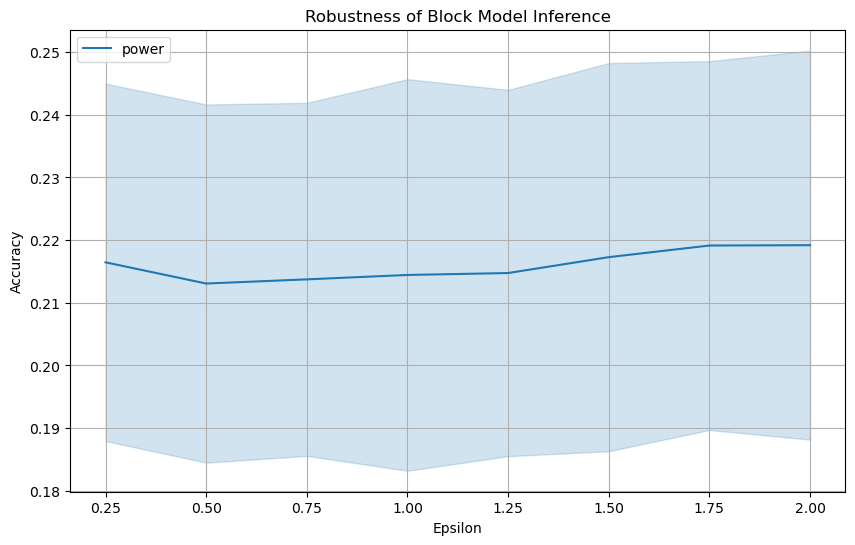

In [7]:
def plot_robustness(dict_datasets):
    plt.figure(figsize=(10, 6))  # Create a single figure for all plots
    for name in dict_datasets:
        data_points = []
    for i in range(5):  # Iterate through the experiments
        for j in range(5): #Iterate through the iterations
            for epsilon, overlap in dict_datasets[name][i][j].items():
                data_points.append({"dataset": name, "experiment": i, "iteration": j,"epsilon": epsilon, "overlap": overlap})

    df = pd.DataFrame(data_points)
    sns.lineplot(x="epsilon", y="overlap", data=df, label=name, markers=True, errorbar="sd") # Use label instead of hue

    plt.title("Robustness of Block Model Inference") # Combined title
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend() # Show legend for all datasets
    plt.show()

# Call the plotting function
plot_robustness(dict_datasets)

# Experiment to compare with Privgraph

In [13]:
!python main_meu.py

Dataset:Chamelon
Node number:2277
Edge number:31371
time_louvain 0.17937994003295898
time_EVC 0.1292109489440918
time_ClustC 0.2548038959503174
time_density 0.02732086181640625
-----------epsilon=0.5,exper=1/3-------------
181806 24936 62742
time_SBM 0.3329930305480957
Nodes=2277,Edges=33268,nmi=0.9890,cc_rel=0.3236,deg_kl=1.5162,mod_rel=0.0040,evc_overlap=0.6818,evc_MAE=0.0279
-----------epsilon=0.5,exper=2/3-------------
181806 25164 62742
time_SBM 0.33276915550231934
Nodes=2277,Edges=33223,nmi=0.9152,cc_rel=0.3129,deg_kl=1.4731,mod_rel=0.0189,evc_overlap=0.7727,evc_MAE=0.0272
-----------epsilon=0.5,exper=3/3-------------
181806 24772 62742
time_SBM 0.325732946395874
Nodes=2277,Edges=33143,nmi=0.9140,cc_rel=0.3176,deg_kl=1.5373,mod_rel=0.0171,evc_overlap=0.6818,evc_MAE=0.0286
all_index=1/7 Done.3.67s

-----------epsilon=1.0,exper=1/3-------------
267574 34154 62742
time_SBM 0.4019887447357178
Nodes=2277,Edges=33835,nmi=0.9981,cc_rel=0.2295,deg_kl=1.0541,mod_rel=0.0092,evc_overlap=0.7

In [15]:
!python main.py

Dataset:Chamelon
Node number:2277
Edge number:31371
-----------epsilon=0.5,exper=1/10-------------
Nodes=2277,Edges=24088,nmi=0.1037,cc_rel=0.8352,deg_kl=2.1322,mod_rel=0.5625,evc_overlap=0.0455,evc_MAE=0.0197,diam_rel=0.5455
-----------epsilon=0.5,exper=2/10-------------
Nodes=2277,Edges=22575,nmi=0.0927,cc_rel=0.8247,deg_kl=2.3890,mod_rel=0.5402,evc_overlap=0.0455,evc_MAE=0.0104,diam_rel=0.5455
-----------epsilon=0.5,exper=3/10-------------
Nodes=2277,Edges=23458,nmi=0.0984,cc_rel=0.8823,deg_kl=2.1349,mod_rel=0.6253,evc_overlap=0.0909,evc_MAE=0.0311,diam_rel=0.5455
-----------epsilon=0.5,exper=4/10-------------
Nodes=2277,Edges=25222,nmi=0.0980,cc_rel=0.8883,deg_kl=2.2782,mod_rel=0.6108,evc_overlap=0.0000,evc_MAE=0.0375,diam_rel=0.5455
-----------epsilon=0.5,exper=5/10-------------
Nodes=2277,Edges=23125,nmi=0.1178,cc_rel=0.7427,deg_kl=2.3348,mod_rel=0.4885,evc_overlap=0.1364,evc_MAE=0.0141,diam_rel=0.5455
-----------epsilon=0.5,exper=6/10-------------
Nodes=2277,Edges=22566,nmi=0.12

In [12]:
df = pd.read_csv('./result/Chamelon_3.csv')
df.head()

,eps,exper,nmi,evc_overlap,evc_MAE,deg_kl,cc_rel,mod_rel
0,0.5,0.0,0.911564,0.727273,0.028919,1.369037,0.336234,0.029246
1,0.5,1.0,0.913644,0.636364,0.027096,1.324342,0.316858,0.025601
2,0.5,2.0,0.911037,0.590909,0.027607,1.389426,0.312593,0.027059
3,1.0,0.0,0.997515,0.863636,0.017077,1.220644,0.230794,0.004879
4,1.0,1.0,0.915147,0.727273,0.018163,2.799546,0.214588,0.024125


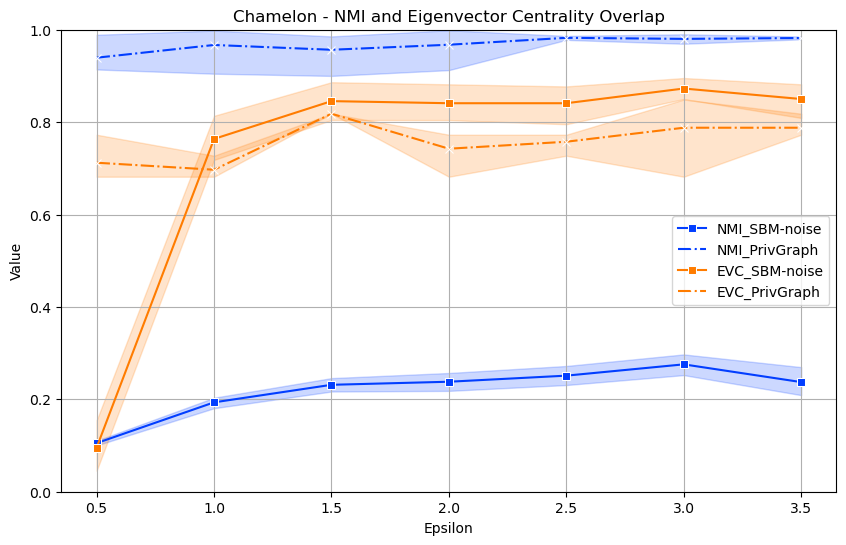

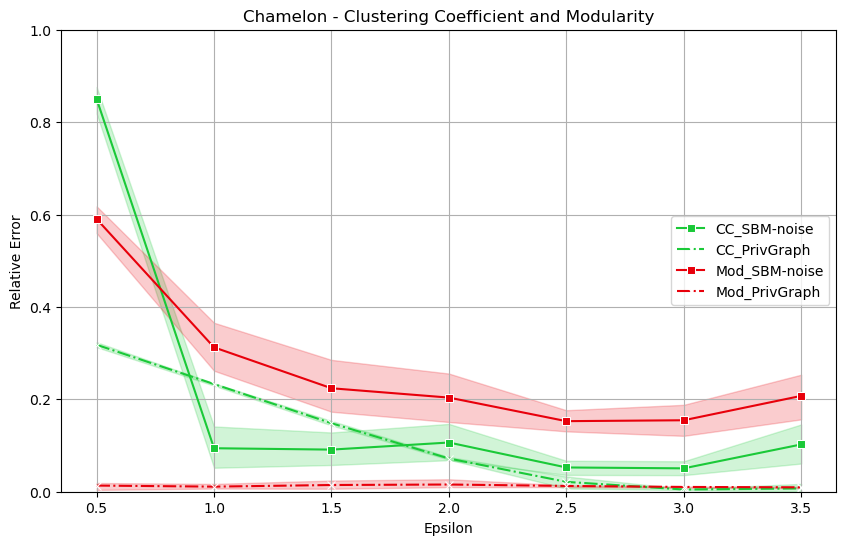

In [18]:
# PLOTS

name = 'Chamelon' # 'CA-HepPh' # 'Facebook' # 'Enron' #
df = pd.read_csv('./result/SBM_Chamelon.csv')
# Load the data from the CSV file into a pandas DataFrame.
df_new = pd.read_csv('./result/PrivGraph_Chamelon.csv')

color_palette = sns.color_palette("bright")

# Assuming the previous plot's data is stored in 'df'

# Create the line plot using seaborn, combining data from both DataFrames
plt.figure(figsize=(10, 6))

# Plot data
sns.lineplot(x='eps', y='nmi', data=df_new, label='NMI_SBM-noise', marker='s', color=color_palette[0])
sns.lineplot(x='eps', y='nmi', data=df, label='NMI_PrivGraph', marker='x', linestyle='dashdot', color=color_palette[0])

sns.lineplot(x='eps', y='evc_overlap', data=df_new, label='EVC_SBM-noise', marker='s', color=color_palette[1])
sns.lineplot(x='eps', y='evc_overlap', data=df, label='EVC_PrivGraph', marker='x', linestyle='dashdot', color=color_palette[1])

# Customize the plot
plt.xlabel('Epsilon')
plt.ylabel('Value')
plt.title('%s - NMI and Eigenvector Centrality Overlap'%(name))
plt.legend(loc='center right')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

##
plt.figure(figsize=(10, 6))

# Plot data from the original 'df'
sns.lineplot(x='eps', y='cc_rel', data=df_new, label='CC_SBM-noise', marker='s', color=color_palette[2])
sns.lineplot(x='eps', y='cc_rel', data=df, label='CC_PrivGraph', marker='x', linestyle='dashdot', color=color_palette[2])
sns.lineplot(x='eps', y='mod_rel', data=df_new, label='Mod_SBM-noise', marker='s', color=color_palette[3])
sns.lineplot(x='eps', y='mod_rel', data=df, label='Mod_PrivGraph', marker='x', linestyle='dashdot', color=color_palette[3])

# Customize the plot
plt.xlabel('Epsilon')
plt.ylabel('Relative Error')
plt.title('%s - Clustering Coefficient and Modularity'%(name))
plt.legend(loc='center right')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Experiments "private-spectral-clustering"

In [23]:
names_dict = {
    'polblogs': {
        'folder': 'political_blogs',
        'edge_file': 'blogs.txt',
        'label_file': 'blogs-orientation.txt'
    },
    # 'fb_simmons': {
    #     'folder': 'fb100',
    #     'edge_file': 'simmons-edges.txt',
    #     'label_file': 'simmons-nodes.txt'
    # },
}

datasets_dict = {}

for dataset in names_dict:
    url = f"https://raw.githubusercontent.com/jonhehir/private-spectral-clustering/master/datasets/{names_dict[dataset]['folder']}/{names_dict[dataset]['label_file']}"
    response = requests.get(url)
    response.raise_for_status()

    communities = np.genfromtxt(io.StringIO(response.text),
                             dtype=str)

    url = f"https://raw.githubusercontent.com/jonhehir/private-spectral-clustering/master/datasets/{names_dict[dataset]['folder']}/{names_dict[dataset]['edge_file']}"
    response = requests.get(url)
    response.raise_for_status()


    edgelist = np.genfromtxt(io.StringIO(response.text),
                             dtype=int,
                             comments='%',
                             )

    M = sparse.coo_matrix((np.ones(edgelist.shape[0]*2),
                        (list(edgelist[:, 0]) + list(edgelist[:, 1]),
                            list(edgelist[:,1]) + list(edgelist[:,0])
                            )
                        ))

    datasets_dict[dataset] = {'edges': M, 'partition': communities}

In [24]:
def label_accuracy(labels, truth):
    """
    max(accuracy) over the set of all label permutations
    truth should be an list of 0-indexed integer labels of length n
    """
    accuracy = 0
    k = max(truth) + 1 # number of labels

    # This is not optimal, but we're using small k, so it's no biggie.
    for p in itertools.permutations(range(k)):
        compare = [p[t] for t in truth]
        accuracy = max(accuracy, metrics.accuracy_score(labels, compare))

    return accuracy

def normalize_rows(U):
    """
    Normalize rows of U to have unit norm
    If a given row has norm == 0, it is left alone
    """
    n = U.shape[0]
    row_norms = np.linalg.norm(U, axis=1).reshape((n, 1))

    # safely divide by norms, leaving original entries if row norm == 0
    return np.divide(U, row_norms, out=U, where=(row_norms > 0))

N_KMEDIANS_INITIALIZATIONS = 10
def cluster_normalized_kmedians(U, k):
    """
    Cluster U by k-medians over row-normalized version of U
    Return labels
    """
    n = U.shape[0]
    U_norm = normalize_rows(U)
    best_labels = None
    best_error = float("inf")

    # Run k-medians multiple times with random initializations, then return best result
    for i in range(N_KMEDIANS_INITIALIZATIONS):
        # for initial centers, choose k points at random
        indices = np.random.choice(n, k, replace=False)
        initial_centers = U_norm[indices, :]

        # run k-medians
        instance = kmedians(U_norm.tolist(), initial_centers.tolist())
        instance.process()

        # get cluster labels (in the format we want them)
        labels = [None] * n
        i = 0
        for c in instance.get_clusters():
            for j in c:
                labels[j] = i
            i += 1

        # calculate error
        medians = np.array(instance.get_medians())
        error = np.sum(np.linalg.norm(U_norm - medians[labels, :], axis=1))

        if error < best_error:
            best_labels = labels
            best_error = error

    return best_labels

def cluster_kmeans(U, k):
    """
    Cluster U by simple k-means
    Return labels
    """
    kmeans = cluster.KMeans(n_clusters=k)
    return kmeans.fit(U).labels_


def recover_labels(A, k, strategy=cluster_kmeans):
    """
    Employ spectral clustering to recover labels for A
    """
    A = A.astype(np.float64)
    U = sparse.linalg.eigsh(A, k)[1]
    return strategy(U, k)

## Experiment "private-spectral-clustering"

In [25]:
# nous EXPERIMENTS "private-spectral-clustering"
exp_list = {dataset: [] for dataset in datasets_dict}
df_dict = {}

# for i in range(1):   #5
for dataset in datasets_dict:
    G = coo_matrix_to_graphtool(datasets_dict[dataset]['edges'])
    v_degrees = G.degree_property_map("total")
    nodes_to_remove = [v for v in G.vertices() if v_degrees[v] == 0]
    G.remove_vertex(nodes_to_remove)

    # convert to categories
    categorical_communities = pd.Series(datasets_dict[dataset]['partition']).astype('category')
    truth = categorical_communities.cat.codes
    k = len(np.unique(truth))  # number of communities

    adj_matrix_symmetric = get_coo_matrix(G, symmetric=True)
    adj_matrix_symmetric = adj_matrix_symmetric.astype(np.float64)

    labels = recover_labels(adj_matrix_symmetric, k, strategy=cluster_normalized_kmedians)
    accuracy = label_accuracy(labels, truth)
    print('base_accuracy', accuracy)

    block_list = labels
    density_matrix = calc_all_densities(adj_matrix_symmetric, block_list)

    print(G)

    added_edges = []
    removed_edges = []
    accuracy_data = []

    epsilon_values = np.arange(0.25, 2.1, 0.25)
    for epsilon in epsilon_values:

        MG = add_SBM(adj_matrix_symmetric, block_list, density_matrix, epsilon)
        NoisyG = coo_matrix_to_graphtool(MG)

        print(NoisyG)
        print('epsilon:', epsilon)

        # metrics
        A_noisy_symmetric = get_coo_matrix(NoisyG, symmetric=True)
        A_noisy_symmetric = A_noisy_symmetric.astype(np.float64)

        labels = recover_labels(A_noisy_symmetric, k, strategy=cluster_normalized_kmedians)
        accuracy = label_accuracy(labels, truth)
        accuracy_data.append(accuracy)
        print('Spectral_accuracy', accuracy)

        M = adj_matrix_symmetric - A_noisy_symmetric
        unique, counts = np.unique(M.data, return_counts=True)

        print(unique, counts/2)
        added_edges.append(counts[0]/2)
        removed_edges.append(counts[1]/2)

    data = {'epsilon': epsilon_values, 'added': added_edges, 'removed': removed_edges, 'accuracy': accuracy_data}
    df_dict[dataset] = pd.DataFrame(data)
    exp_list[dataset].append(df_dict[dataset])

base_accuracy 0.9477124183006536
<Graph object, undirected, with 1224 vertices and 16715 edges, at 0x30f726a30>
81772 3276.0 33430.0
<Graph object, undirected, with 1224 vertices and 17196 edges, at 0x30f15fc50>
epsilon: 0.25
Spectral_accuracy 0.9477124183006536
[-1.  1.] [15650. 15169.]
103506 4100.0 33430.0
<Graph object, undirected, with 1224 vertices and 17110 edges, at 0x30f15c190>
epsilon: 0.5
Spectral_accuracy 0.9477124183006536
[-1.  1.] [15181. 14786.]
130520 5348.0 33430.0
<Graph object, undirected, with 1224 vertices and 17622 edges, at 0x1673325d0>
epsilon: 0.75
Spectral_accuracy 0.9477124183006536
[-1.  1.] [15160. 14253.]
163826 6442.0 33430.0
<Graph object, undirected, with 1224 vertices and 17718 edges, at 0x30f2afe30>
epsilon: 1.0
Spectral_accuracy 0.9477124183006536
[-1.  1.] [14819. 13816.]
204470 8212.0 33430.0
<Graph object, undirected, with 1224 vertices and 18254 edges, at 0x30f2af7f0>
epsilon: 1.25
Spectral_accuracy 0.9477124183006536
[-1.  1.] [14638. 13099.]
2

In [26]:
# Create a list to store the results for each dataset
results = []

# Iterate over the datasets
for dataset, df_list in exp_list.items():
  df = pd.concat(df_list)

  # Calculate the average values for each epsilon
  avg_accuracy_epsilon = df.groupby('epsilon')['accuracy'].mean().reset_index()
  avg_added_epsilon = df.groupby('epsilon')['added'].mean().reset_index()
  avg_removed_epsilon = df.groupby('epsilon')['removed'].mean().reset_index()

  # Merge the average values into a single DataFrame
  merged_df = pd.merge(avg_accuracy_epsilon, avg_added_epsilon, on='epsilon')
  merged_df = pd.merge(merged_df, avg_removed_epsilon, on='epsilon')

  # Add dataset name to the table
  merged_df['dataset'] = dataset
  results.append(merged_df)

# Concatenate the results for all datasets into a single table
final_table = pd.concat(results)

# Display the table
print("Average Accuracy, Added, and Removed Edges for each Epsilon and Dataset:")
final_table

Average Accuracy, Added, and Removed Edges for each Epsilon and Dataset:


,epsilon,accuracy,added,removed,dataset
0,0.25,0.947712,15650.0,15169.0,polblogs
1,0.50,0.947712,15181.0,14786.0,polblogs
2,0.75,0.947712,15160.0,14253.0,polblogs
3,1.00,0.947712,14819.0,13816.0,polblogs
4,1.25,0.947712,14638.0,13099.0,polblogs
5,1.50,0.947712,13941.0,12404.0,polblogs
6,1.75,0.947712,13588.0,11568.0,polblogs
7,2.00,0.947712,12631.0,10651.0,polblogs


# repeat Spectral Clustering results


In [ ]:
!git clone https://github.com/jonhehir/private-spectral-clustering
%cd private-spectral-clustering/

In [29]:
# Functions from "private-spectral-clustering"
def generate_block(size, prob, symmetric=False):
    return generate_sparse_block(size, prob, symmetric=symmetric).toarray()


def generate_sparse_block(size, prob, symmetric=False):
    """
    Generates a random block of binary entries where each entry is 1 w.p. prob
    If symmetric=True, returns a symmetric block with a zero on the diagonal.
    """
    density = stats.binom.rvs(size[0] * size[1], prob, size=1).item() / (size[0] * size[1])
    m = sparse.random(size[0], size[1], density)
    m.data[:] = 1

    if symmetric:
        if size[0] != size[1]:
            raise RuntimeError("symmetric matrix must be square")
        m = sparse.triu(m, k=1) + sparse.triu(m, k=1).transpose()

    return m

# Hardcoded number of random initializations to try for k-medians
N_KMEDIANS_INITIALIZATIONS = 10

def cluster_kmeans(U, k):
    """
    Cluster U by simple k-means
    Return labels
    """
    kmeans = cluster.KMeans(n_clusters=k)
    return kmeans.fit(U).labels_

def recover_labels(A, k, strategy=cluster_kmeans):
    """
    Employ spectral clustering to recover labels for A
    """
    U = sparse.linalg.eigsh(A, k)[1]
    return strategy(U, k)

def normalize_rows(U):
    """
    Normalize rows of U to have unit norm
    If a given row has norm == 0, it is left alone
    """
    n = U.shape[0]
    row_norms = np.linalg.norm(U, axis=1).reshape((n, 1))

    # safely divide by norms, leaving original entries if row norm == 0
    return np.divide(U, row_norms, out=U, where=(row_norms > 0))

def cluster_normalized_kmedians(U, k):
    """
    Cluster U by k-medians over row-normalized version of U
    Return labels
    """
    n = U.shape[0]
    U_norm = normalize_rows(U)
    best_labels = None
    best_error = float("inf")

    # Run k-medians multiple times with random initializations, then return best result
    for i in range(N_KMEDIANS_INITIALIZATIONS):
        # for initial centers, choose k points at random
        indices = np.random.choice(n, k, replace=False)
        initial_centers = U_norm[indices, :]

        # run k-medians
        instance = kmedians(U_norm.tolist(), initial_centers.tolist())
        instance.process()

        # get cluster labels (in the format we want them)
        labels = [None] * n
        i = 0
        for c in instance.get_clusters():
            for j in c:
                labels[j] = i
            i += 1

        # calculate error
        medians = np.array(instance.get_medians())
        error = np.sum(np.linalg.norm(U_norm - medians[labels, :], axis=1))

        if error < best_error:
            best_labels = labels
            best_error = error

    return best_labels

def label_accuracy(labels, truth):
    """
    max(accuracy) over the set of all label permutations
    truth should be an list of 0-indexed integer labels of length n
    """
    accuracy = 0
    k = max(truth) + 1 # number of labels

    # This is not optimal, but we're using small k, so it's no biggie.
    for p in itertools.permutations(range(k)):
        compare = [p[t] for t in truth]
        accuracy = max(accuracy, metrics.accuracy_score(labels, compare))

    return accuracy

def preprocess_recenter(M, eps):
    """
    Subtracts 1/(e^eps + 1) from off-diagonals of M
    """
    p = perturb_prob(eps)
    return M - p + np.diag([p] * M.shape[0])


def perturb_prob(eps):
    """
    P(perturb edge)
    """
    return 1 / (np.exp(eps) + 1)


def perturb_symmetric(m, eps):
    """
    Perturb a symmetric adjacency matrix using edge flips
    Note: This retains a zero on the diagonal.
    """
    p = perturb_prob(eps)
    error = generate_block(m.shape, p, symmetric = True)
    return abs(m - error)


# REPEAT EXPERIMENTS "private-spectral-clustering"
exp_list = {dataset: [] for dataset in datasets_dict}
df_dict = {}

# for i in range(5):   #5
for dataset in datasets_dict:
    G = coo_matrix_to_graphtool(datasets_dict[dataset]['edges'])
    v_degrees = G.degree_property_map("total")
    nodes_to_remove = [v for v in G.vertices() if v_degrees[v] == 0]
    G.remove_vertex(nodes_to_remove)


    # convert to categories
    categorical_communities = pd.Series(datasets_dict[dataset]['partition']).astype('category')
    truth = categorical_communities.cat.codes
    k = len(np.unique(truth))  # number of communities

    ###########

    adj_matrix_symmetric = get_coo_matrix(G, symmetric=True)
    adj_matrix_symmetric = adj_matrix_symmetric.astype(np.float64)
    # adj_matrix = get_coo_matrix(G) #adjacency(G)


    labels = recover_labels(adj_matrix_symmetric, k, strategy=cluster_normalized_kmedians)
    accuracy = label_accuracy(labels, truth)
    print('base_accuracy', accuracy)


    block_list = labels

    print(G)

    added_edges = []
    removed_edges = []
    accuracy_data = []

    epsilon_values = np.arange(0.25, 2.1, 0.25)
    for epsilon in epsilon_values:

        if epsilon >= 0:
           A = preprocess_recenter(perturb_symmetric(adj_matrix_symmetric, epsilon), epsilon)

        labels = recover_labels(A, k, strategy=cluster_normalized_kmedians)

        print('epsilon:', epsilon)

        # metrics
        A_noisy_symmetric = A

        labels = recover_labels(A_noisy_symmetric, k, strategy=cluster_normalized_kmedians)
        accuracy = label_accuracy(labels, truth)
        accuracy_data.append(accuracy)
        print('Spectral_accuracy', accuracy)

        M = adj_matrix_symmetric - A_noisy_symmetric
        unique, counts = np.unique(M.data, return_counts=True)

        print(unique, counts/2)
        added_edges.append(counts[0]/2)
        removed_edges.append(counts[1]/2)

    data = {'epsilon': epsilon_values, 'added': added_edges, 'removed': removed_edges, 'accuracy': accuracy_data}

    df_dict[dataset] = pd.DataFrame(data)

    exp_list[dataset].append(df_dict[dataset])

base_accuracy 0.9468954248366013
<Graph object, undirected, with 1224 vertices and 16715 edges, at 0x30f2ad450>
epsilon: 0.25
Spectral_accuracy 0.5032679738562091
[-0.5621765  0.         0.4378235  1.4378235] [320571.    612. 420585.   7320.]
epsilon: 0.5
Spectral_accuracy 0.5098039215686274
[-0.62245933  0.          0.37754067  1.37754067] [276119.    612. 466049.   6308.]
epsilon: 0.75
Spectral_accuracy 0.6584967320261438
[-0.6791787  0.         0.3208213  1.3208213] [234204.    612. 508798.   5474.]
epsilon: 1.0
Spectral_accuracy 0.7181372549019608
[-0.73105858  0.          0.26894142  1.26894142] [197021.    612. 546965.   4490.]
epsilon: 1.25
Spectral_accuracy 0.7352941176470589
[-0.77729986  0.          0.22270014  0.22270014  1.22270014] [162645.    612.  13006. 569116.   3709.]
epsilon: 1.5
Spectral_accuracy 0.7712418300653595
[-0.81757448  0.          0.18242552  1.18242552] [1.32525e+05 6.12000e+02 6.12922e+05 3.02900e+03]
epsilon: 1.75
Spectral_accuracy 0.7883986928104575
[-

In [30]:
exp_list

{'polblogs': [   epsilon     added  removed  accuracy
  0     0.25  320571.0    612.0  0.503268
  1     0.50  276119.0    612.0  0.509804
  2     0.75  234204.0    612.0  0.658497
  3     1.00  197021.0    612.0  0.718137
  4     1.25  162645.0    612.0  0.735294
  5     1.50  132525.0    612.0  0.771242
  6     1.75  108834.0    612.0  0.788399
  7     2.00   87489.0    612.0  0.791667]}

In [31]:
# Create a list to store the results for each dataset
results = []

# Iterate over the datasets
for dataset, df_list in exp_list.items():
  df = pd.concat(df_list)

  avg_accuracy_epsilon = df.groupby('epsilon')['accuracy'].mean().reset_index()

  # Add dataset name to the table
  avg_accuracy_epsilon['dataset'] = dataset
  results.append(avg_accuracy_epsilon)

# Concatenate the results for all datasets into a single table
avg_accuracy_table = pd.concat(results)

# Display the table with average accuracy for each epsilon and dataset
print("Average Accuracy for each Epsilon and Dataset:")
print(avg_accuracy_table)


Average Accuracy for each Epsilon and Dataset:
   epsilon  accuracy   dataset
0     0.25  0.503268  polblogs
1     0.50  0.509804  polblogs
2     0.75  0.658497  polblogs
3     1.00  0.718137  polblogs
4     1.25  0.735294  polblogs
5     1.50  0.771242  polblogs
6     1.75  0.788399  polblogs
7     2.00  0.791667  polblogs
